# Instacart EDA

In [206]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns


In [258]:
# Stylesheet
# plt.style.use('seaborn-v0_8-pastel')
plt.style.use('default')

### Load data

In [197]:
orders = pd.read_csv('data/orders.csv')
aisles = pd.read_csv('data/aisles.csv')
products = pd.read_csv('data/products.csv')
order_products_prior = pd.read_csv('data/order_products__prior.csv')
order_products_train = pd.read_csv('data/order_products__train.csv')
depts = pd.read_csv('data/departments.csv')

### Inspect Orders file

In [209]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,0.0
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [210]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


In [211]:
orders.isnull().sum()

order_id                  0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
dtype: int64

### Handle missing values in days_since_prior_order column

In [212]:
orders[orders.days_since_prior_order.isnull()]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order


In [213]:
print(orders[orders.days_since_prior_order.isnull()].order_number.min())
print(orders[orders.days_since_prior_order.isnull()].order_number.max())

nan
nan


In [214]:
# Missing values is associated to the very first order a customer places, so this can be imputed with zero
orders.days_since_prior_order.fillna(0, inplace=True)
orders.isnull().sum()

order_id                  0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
dtype: int64

In [215]:
# Export to csv to visualise in tableau later
orders.to_csv('data/orders_cleaned.csv', index=False)

### Evaluation set count

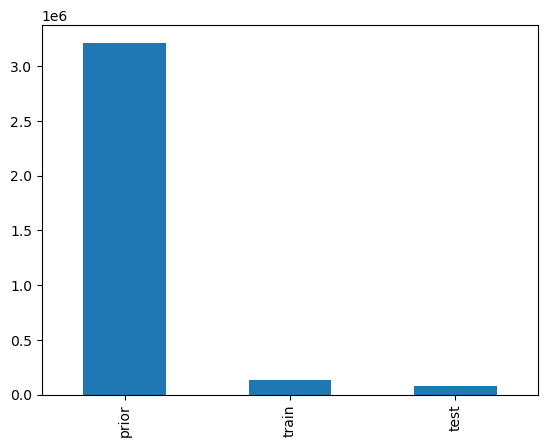

In [216]:
orders.eval_set.value_counts().plot(kind='bar');

### How many users?

In [217]:
orders.user_id.nunique()

206209

### EDA - Order level

In [218]:
orders.describe().apply(lambda x: x.apply('{0:.5f}'.format))

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3421083.00000,3421083.00000,3421083.00000,3421083.00000,3421083.00000,3421083.00000
mean,1710542.00000,102978.20806,17.15486,2.77622,13.45202,10.44488
std,987581.73982,59533.71779,17.73316,2.04683,4.22609,9.30873
min,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000
25%,855271.50000,51394.00000,5.00000,1.00000,10.00000,4.00000
50%,1710542.00000,102689.00000,11.00000,3.00000,13.00000,7.00000
75%,2565812.50000,154385.00000,23.00000,5.00000,16.00000,15.00000
max,3421083.00000,206209.00000,100.00000,6.00000,23.00000,30.00000


#### What day of the week do most orders occur and least orders occur?

In [219]:
dow_count = orders.groupby('order_dow')['order_id'].agg(['count'])
dow_count

,count
order_dow,
0,600905
1,587478
2,467260
3,436972
4,426339
5,453368
6,448761


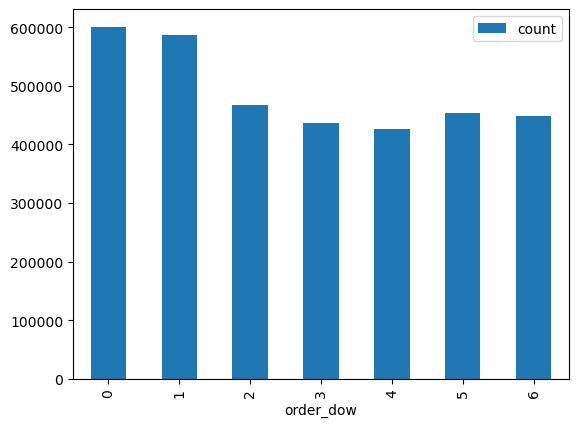

In [220]:
dow_count.plot(kind='bar');

- It's not specified on instacart's data dictionary nor has it been confirmed in kaggle discussions which day each of these numbers represent. Given it's a North American company, I will assume that day 0 is Sunday, which is when most orders occur and the lowest orders occur on Thursdays.

#### What hour of the day do most and least orders occur?

In [221]:
hour_of_orders = orders.groupby('order_hour_of_day')['order_id'].agg(['count'])

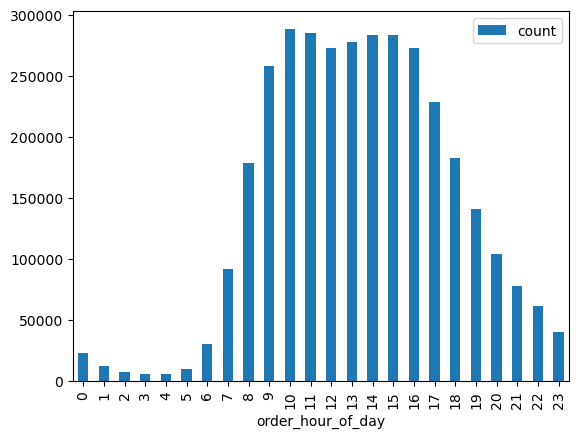

In [222]:
hour_of_orders.plot(kind='bar');

In [ ]:
orders.groupby('order_hour_of_day')['order_id'].agg(['count'])

- The highest amount of orders placed is between the hours of 10-11am
- More orders are placed between 10am to 4pm than any other time of the day. That makes up 57% of total orders placed.

#### What's the lag in time between orders?

<AxesSubplot: xlabel='days_since_prior_order'>

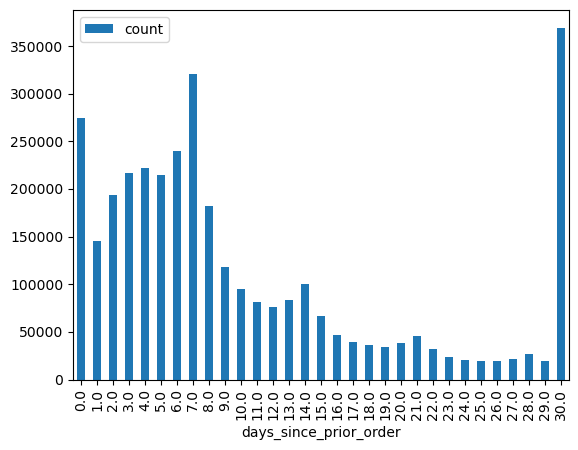

In [223]:
orders.groupby('days_since_prior_order')['order_id'].agg(['count']).plot(kind='bar')

- Most frequent lag is 30 days followed by 7 days.
- Note that instacart has intentially capped the lag to 30 days

### Inspect products

In [224]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [225]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


### Inspect prior product-level details of orders
- contains what products was orders for each order
- the order in which the products were placed in the shopping cart
- an indicator if the user has ordered this product in the past: 1 = yes, 0 = no

In [226]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [227]:
# How many prior orders overall?
order_products_prior.shape

(32434489, 4)

### Inspect aisles

In [228]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [229]:
aisles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


### Inspect departments

In [230]:
depts.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [231]:
depts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 464.0+ bytes


### Merge product data with aisle and department data

In [232]:
# Join products, aisles, and departments into 1 dataframe
products_master = products.merge(aisles, 
                                           how='left', 
                                           on='aisle_id').merge(depts, 
                                                                how='left', 
                                                                on='department_id')
products_master

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry
...,...,...,...,...,...,...
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5,spirits,alcohol
49684,49685,En Croute Roast Hazelnut Cranberry,42,1,frozen vegan vegetarian,frozen
49685,49686,Artisan Baguette,112,3,bread,bakery
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8,cat food care,pets


In [233]:
order_products_prior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 989.8 MB


In [234]:
order_products_train.isnull().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [235]:
order_products_prior

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


### Merge prior orders and products data

In [236]:
prior_orders = order_products_prior.merge(orders, 
                                              how='left', 
                                              on='order_id').merge(products_master, 
                                                                   how='left', 
                                                                   on='product_id')

In [237]:
prior_orders = prior_orders.sort_values(by=['user_id', 'order_number'])

In [238]:
prior_orders.shape

(32434489, 15)

### EDA - Product-level

#### What products receives the highest amount of orders?

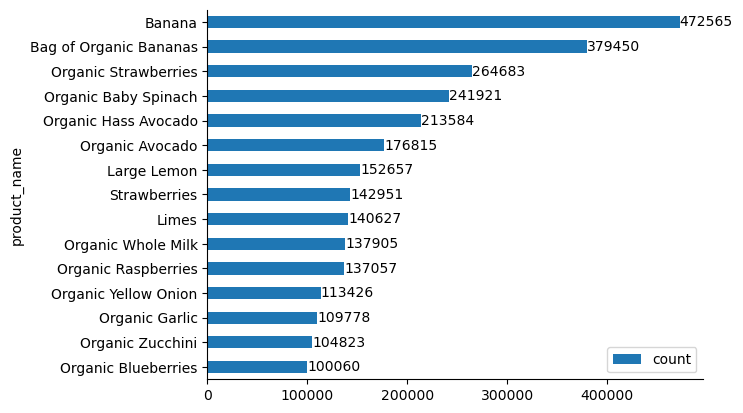

In [239]:
product_order_frequency = prior_orders.groupby('product_name')['order_id'].agg(['count']).sort_values(by='count', ascending=False)
ax = product_order_frequency.head(15).sort_values(by='count', ascending=True).plot.barh()
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge');
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [255]:
product_order_frequency.rename(columns={'count': 'total_orders'}, inplace=True)
product_order_frequency

,total_orders
product_name,
Banana,472565
Bag of Organic Bananas,379450
Organic Strawberries,264683
Organic Baby Spinach,241921
Organic Hass Avocado,213584
...,...
Pure Performance Restorative Shampoo Chamomile & Honey,1
Lindor Peppermint White Chocolate Truffles,1
Dynostix Rawhide Chew With Meat,1


- Bananas, strawberries, and avocado are very popular items

In [240]:
product_frequency_reorders = prior_orders.groupby('product_name')['reordered'].agg(['sum']).sort_values(by='sum', ascending=False)
product_frequency_reorders.rename(columns={'sum': 'reorder_count'}, inplace=True)
product_frequency_reorders

,reorder_count
product_name,
Banana,398609
Bag of Organic Bananas,315913
Organic Strawberries,205845
Organic Baby Spinach,186884
Organic Hass Avocado,170131
...,...
Decorating Green Cake Icing,0
Lemon Ice Tea Liquid,0
"Decorating Gel, Red",0


In [353]:
product_reorder_ratio = product_order_frequency.merge(product_frequency_reorders, how='left', on='product_name')
product_reorder_ratio['product_reorder_ratio'] = product_reorder_ratio.reorder_count / product_reorder_ratio.total_orders
product_reorder_ratio.sort_values(by='product_reorder_ratio', ascending=False)

,total_orders,reorder_count,product_reorder_ratio
product_name,,,
Raw Veggie Wrappers,68,64,0.941176
Serenity Ultimate Extrema Overnight Pads,87,81,0.931034
Orange Energy Shots,13,12,0.923077
Chocolate Love Bar,101,93,0.920792
Soy Powder Infant Formula,35,32,0.914286
...,...,...,...
Cushioned Nail Board,6,0,0.000000
Lavender Relaxing Body Oil,6,0,0.000000
Potato Chips Regualr Party Size Original,14,0,0.000000


#### Which aisles receives the highest amount of orders?

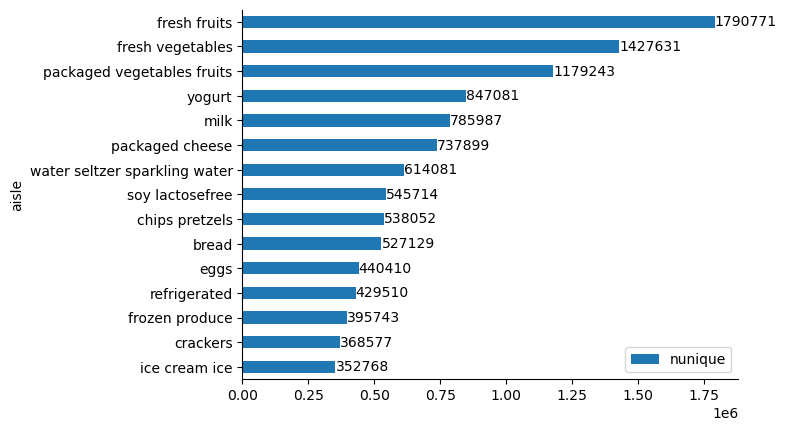

In [259]:
aisle_frequency = prior_orders.groupby('aisle')['order_id'].agg(['nunique']).sort_values(by='nunique', ascending=False)
ax = aisle_frequency.head(15).sort_values(by='nunique', ascending=True).plot.barh()
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge');
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


- Fresh fruits and fresh vegetables are by far the top 2 popular aisles that customers order from.

#### Which aisles receive the highest amount of reorders

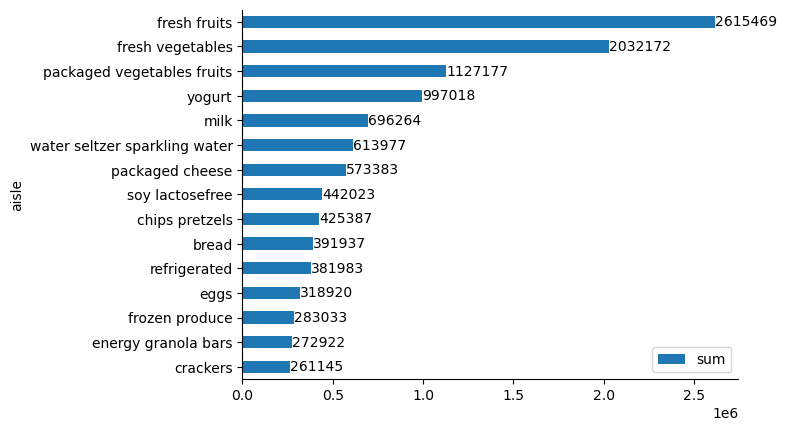

In [260]:
aisle_frequency_reorders = prior_orders.groupby('aisle')['reordered'].agg(['sum']).sort_values(by='sum', ascending=False)
ax = aisle_frequency_reorders.head(15).sort_values(by='sum', ascending=True).plot.barh()
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge');
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#### Which department receives the highest amount of orders?

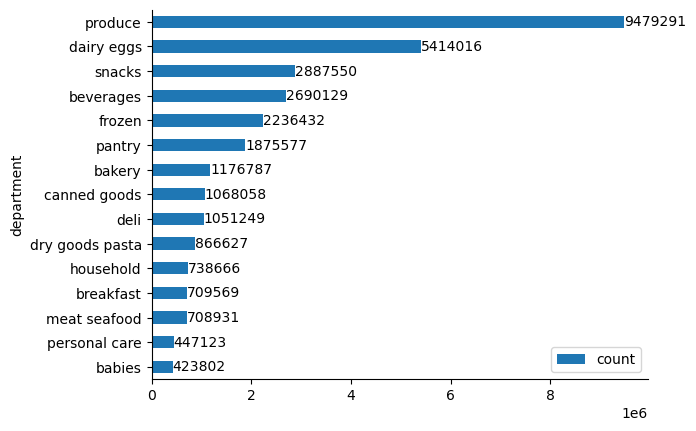

In [261]:
department_frequency = prior_orders.groupby('department')['order_id'].agg(['count']).sort_values(by='count', ascending=False)
ax = department_frequency.head(15).sort_values(by='count', ascending=True).plot.barh()
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge');
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

- Going a level up in product category, the produce and diary eggs are the top 2 departments that customers shop at.

#### Which department receives the highest amount of reorders?

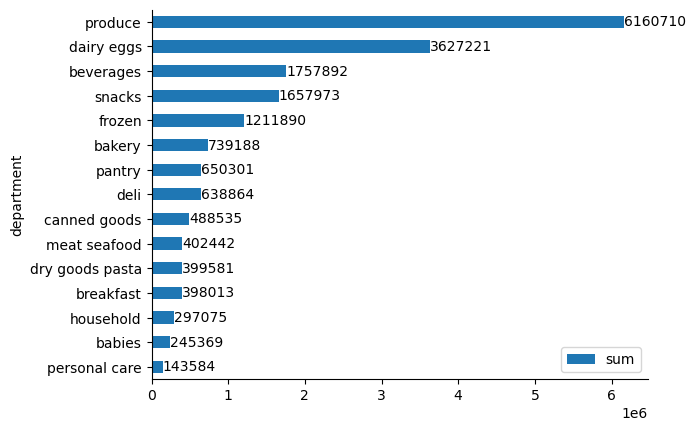

In [262]:
department_frequency_reorders = prior_orders.groupby('department')['reordered'].agg(['sum']).sort_values(by='sum', ascending=False)
ax = department_frequency_reorders.head(15).sort_values(by='sum', ascending=True).plot.barh()
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge');
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#### How many products on average on each order?

In [263]:
products_per_order = prior_orders.groupby('order_id')['product_id'].agg(['count'])
products_per_order.mean()

count    10.088883
dtype: float64

<AxesSubplot: xlabel='count', ylabel='Count'>

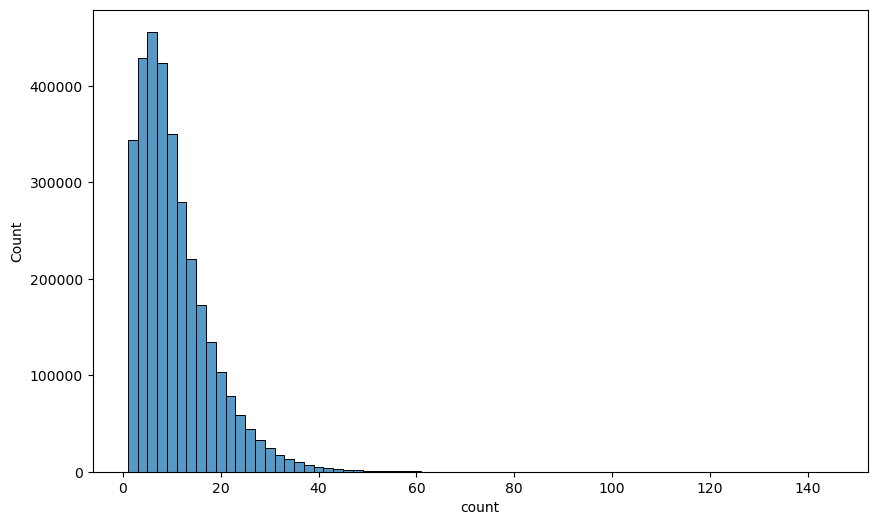

In [264]:
plt.figure(figsize=(10,6))
sns.histplot(data=products_per_order, x='count', binwidth=2)


#### Which products have shorter reorder cycles?

In [265]:
prior_orders_reorders = prior_orders[prior_orders['days_since_prior_order'] != 0]

In [266]:
prior_orders_reorders.groupby('product_name')['days_since_prior_order'].agg(['mean']).sort_values(by='mean').head(15)

,mean
product_name,
Pomegranate Energy Shot,1.000000
Black Olive Spread,1.000000
Chinese Barbecue Sauce,1.500000
10 Grain Bread Mix,1.500000
Thyme & Honey Goat Cheese,1.500000
Iced Green Tea Zero Calorie Citrus,1.500000
White Birthday Candles,1.666667
Anti Itch Concentrated Lotion,2.000000
"Fruities On-the-Go Apple, Mango, & Carrot Puree",2.000000


#### Which aisles have shorter reorder cycles

In [267]:
prior_orders_reorders.groupby('aisle')['days_since_prior_order'].agg(['mean']).sort_values(by='mean').head(15)

,mean
aisle,
baby accessories,9.780894
baby food formula,10.063505
bulk dried fruits vegetables,10.158002
spirits,10.190865
white wines,10.230851
missing,10.398135
vitamins supplements,10.468506
bulk grains rice dried goods,10.474918
candy chocolate,10.483155


#### Which department has short reorder cycles

In [268]:
prior_orders_reorders.groupby('department')['days_since_prior_order'].agg(['mean']).sort_values(by='mean').head(15)

,mean
department,
babies,10.106763
bulk,10.314853
missing,10.398135
alcohol,10.689203
produce,11.013162
snacks,11.131066
dairy eggs,11.138036
other,11.189689
beverages,11.245463


#### How many unique products have reordered = 1? Express in terms of percent of all products

In [269]:
prior_orders[prior_orders.reordered == 1]['product_name'].nunique() / products.product_id.nunique()

0.9117895668974401

#### Which products are higher up in cart position? Sort by first to last position

In [270]:
prior_orders.groupby('product_name')['add_to_cart_order'].agg(['mean']).sort_values(by='mean')

,mean
product_name,
Chocolate Peppermint Tart,1.000000
Easter Basket,1.000000
American Blend,1.000000
Spicy Falafel,1.000000
"Indoor & Outdoor Allergies, Allergy & Congestion, 24 Hour, Extended Release Tablets",1.000000
...,...
Jalapeno Babies,36.666667
Eczema Control,41.000000
Vanilla Bean Sheep Milk Ice Cream,46.000000


#### Which aisles are higher up in cart position?

In [271]:
aisle_median_cart_pos= prior_orders.groupby('aisle')['add_to_cart_order'].agg(['mean']).sort_values(by='mean')
aisle_median_cart_pos

,mean
aisle,
spirits,4.852751
packaged produce,5.123578
specialty wines champagnes,5.205930
beers coolers,5.342315
milk,5.570370
...,...
dry pasta,10.356121
latino foods,10.420110
salad dressing toppings,10.507032


### EDA - User-level

In [272]:
prior_orders.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
24076664,2539329,196,1,0,1,prior,1,2,8,0.0,Soda,77,7,soft drinks,beverages
24076665,2539329,14084,2,0,1,prior,1,2,8,0.0,Organic Unsweetened Vanilla Almond Milk,91,16,soy lactosefree,dairy eggs
24076666,2539329,12427,3,0,1,prior,1,2,8,0.0,Original Beef Jerky,23,19,popcorn jerky,snacks
24076667,2539329,26088,4,0,1,prior,1,2,8,0.0,Aged White Cheddar Popcorn,23,19,popcorn jerky,snacks
24076668,2539329,26405,5,0,1,prior,1,2,8,0.0,XL Pick-A-Size Paper Towel Rolls,54,17,paper goods,household


#### How many orders does a customer place on average?

In [273]:
avg_orders = orders.groupby('user_id')['order_id'].agg(['count']).mean()
median_orders= orders.groupby('user_id')['order_id'].agg(['count']).median()
print(f"Average of no. orders placed = {int(avg_orders)}")
print(f"Median of no. orders placed = {int(median_orders)}")

Average of no. orders placed = 16
Median of no. orders placed = 10


In [274]:
user_orders_cnt = orders.groupby('user_id')['order_id'].agg(['count'])
user_orders_cnt.head()

,count
user_id,
1,11
2,15
3,13
4,6
5,5


In [275]:
user_orders_cnt.value_counts()

count
4        23986
5        19590
6        16165
7        13850
8        11700
         ...  
94          57
91          56
97          54
98          50
99          47
Length: 97, dtype: int64

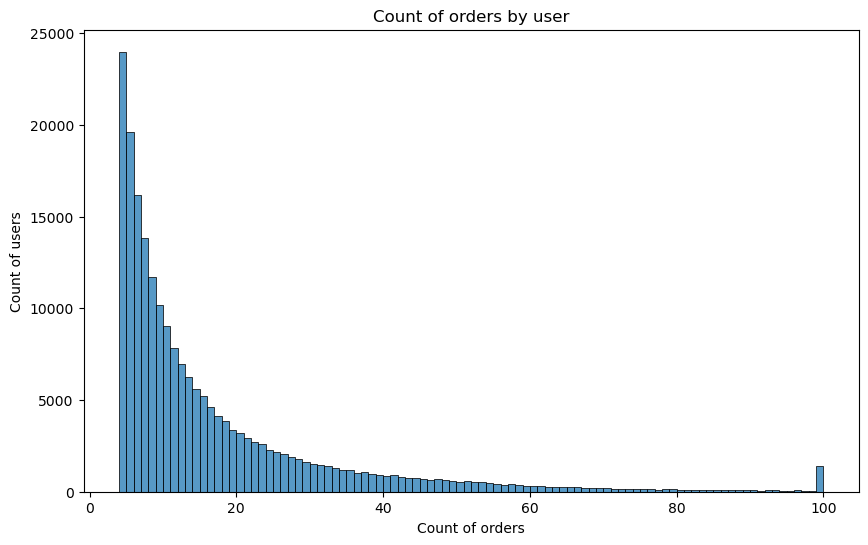

In [276]:
plt.figure(figsize=(10,6))
sns.histplot(data= user_orders_cnt, x='count', binwidth=1)
plt.title('Count of orders by user')
plt.xlabel('Count of orders')
plt.ylabel('Count of users')
plt.show()

- 4 orders is the most common number of orders. Over 20,000 users place 4 orders. That's 12% of all users

#### On average, what day of week does a customer place an order?

In [277]:
user_median_dow = orders.groupby('user_id')['order_dow'].agg(['median']).median()
user_median_dow

median    3.0
dtype: float64

In [278]:
# sns.histplot(data=user_orders_dow_avg, x='mean', bins=20)

- Most users 

#### On average, what hour of the day does a customer place an order?

In [279]:
orders.groupby('user_id')['order_hour_of_day'].agg(['median']).median()

median    13.5
dtype: float64

#### On average, how many days past before a user orders again?

In [280]:
orders.groupby('user_id')['days_since_prior_order'].agg(['median']).median()

median    11.0
dtype: float64

#### How many users that days since prior orders = 30 days?

In [349]:
orders[orders.days_since_prior_order == 30]['user_id'].nunique()

152012

## Comparing reorders vs non-reorders

#### By Day of week

<AxesSubplot: xlabel='reordered', ylabel='order_dow'>

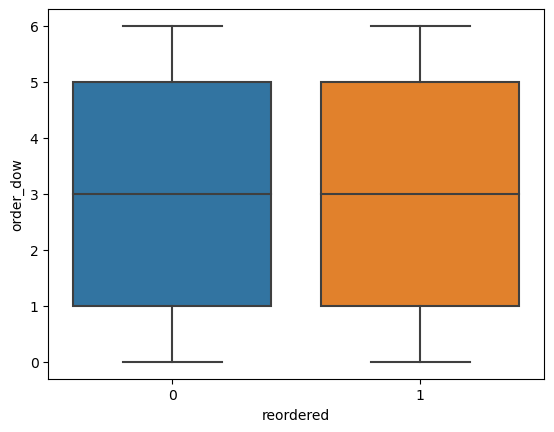

In [281]:
sns.boxplot(data=prior_orders, x='reordered', y='order_dow')

- No apparent differences at this level. However, preferred day of week for reordering will be different between users.

In [282]:
# sns.pairplot(data=prior_orders, hue='reordered', 
#              vars=['add_to_cart_order', 
#                    'order_number', 
#                    'order_dow', 
#                    'order_hour_of_day', 
#                    'days_since_prior_order'])
# sns.savefig("pairplot.png")
# plt.clf()
# Image(filename="pairplot.png")

#### By Hour of Day

<AxesSubplot: xlabel='order_hour_of_day', ylabel='Count'>

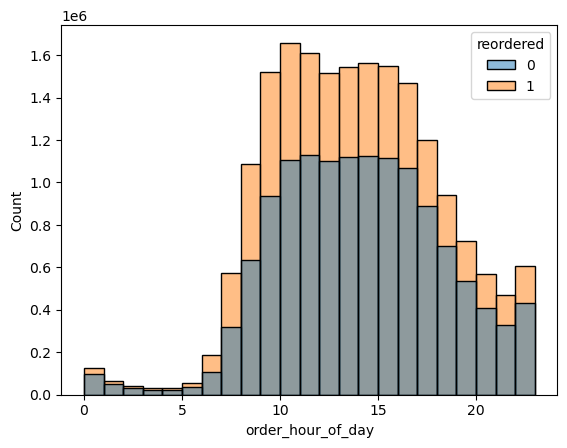

In [283]:
sns.histplot(data = prior_orders, x = 'order_hour_of_day', hue ='reordered', binwidth=1)

- No difference in pattern with hour of day

<AxesSubplot: xlabel='reordered', ylabel='order_hour_of_day'>

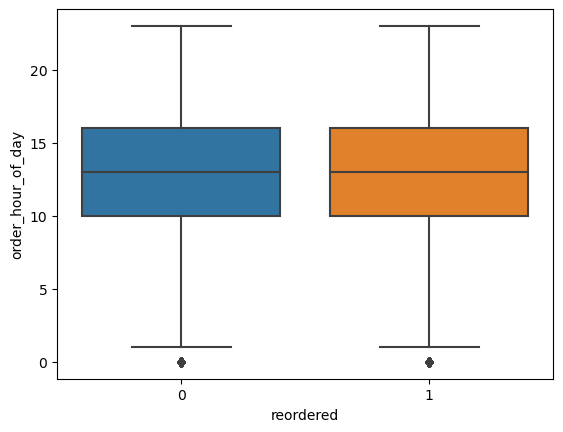

In [284]:
sns.boxplot(data = prior_orders, x = 'reordered', y='order_hour_of_day')

#### By add cart position

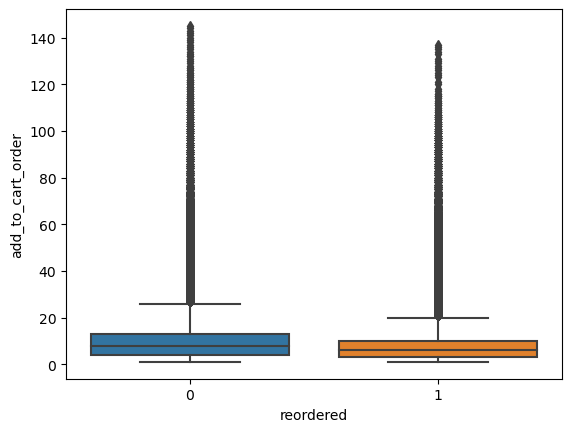

In [285]:
sns.boxplot(prior_orders, x = 'reordered', y = 'add_to_cart_order');

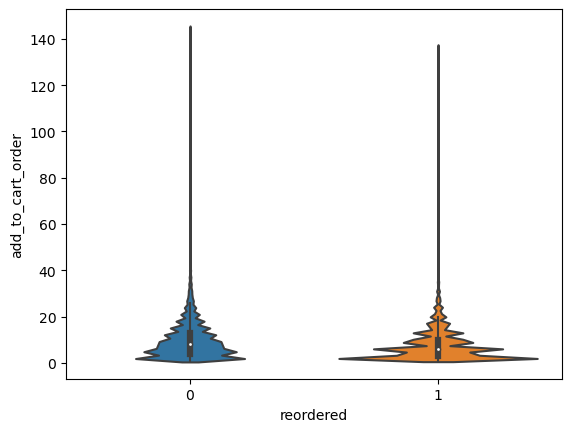

In [286]:
sns.violinplot(prior_orders, x = 'reordered', y = 'add_to_cart_order');

- From the boxplot, the reordered class have a higher position in the cart than Non-reordered class.
- Looking at the violin plot, there's also lot more density in the higher positions.
- May be a good predictor variable

#### By days since prior order

<AxesSubplot: xlabel='days_since_prior_order', ylabel='Count'>

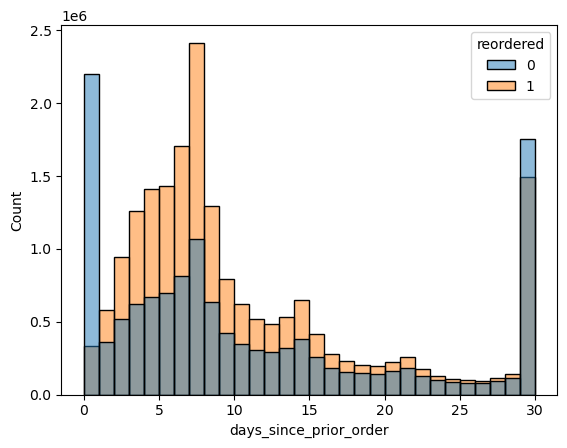

In [288]:
sns.histplot(prior_orders, x = 'days_since_prior_order', hue ='reordered', binwidth=1)

<AxesSubplot: xlabel='reordered', ylabel='days_since_prior_order'>

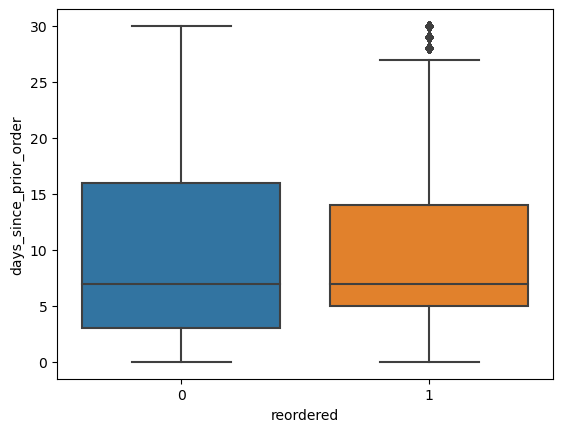

In [289]:
sns.boxplot(prior_orders, x = 'reordered', y = 'days_since_prior_order')

- Reordered class lower median value and a smaller range of values than the Non-reorder class. This suggests that Reordered class has shorter ordering cyles. 
- This could be a good predictor variable

In [290]:
last_orders = order_products_train.merge(orders, 
                                              how='left', 
                                              on='order_id').merge(products_master, 
                                                                   how='left', 
                                                                   on='product_id')

In [291]:
last_orders.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,1,11109,2,1,112108,train,4,4,10,9.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs
2,1,10246,3,0,112108,train,4,4,10,9.0,Organic Celery Hearts,83,4,fresh vegetables,produce
3,1,49683,4,0,112108,train,4,4,10,9.0,Cucumber Kirby,83,4,fresh vegetables,produce
4,1,43633,5,1,112108,train,4,4,10,9.0,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods


### How many customers represented in the last orders?

In [292]:
last_orders.user_id.nunique()

131209

## Feature Engineering

In [293]:
prior_orders.shape

(32434489, 15)

### Product features

#### Product Feature 1: Average position in cart for each product
Hypothesis: Products added to the cart first may be items users need regularly

In [294]:
p_avg_cart_pos_df = prior_orders.groupby('product_id')['add_to_cart_order'].agg(['mean']).reset_index()
p_avg_cart_pos_df.rename(columns={'mean' : 'p_mean_cart_position'}, inplace=True)
p_avg_cart_pos_df

,product_id,p_mean_cart_position
0,1,5.801836
1,2,9.888889
2,3,6.415162
3,4,9.507599
4,5,6.466667
...,...,...
49672,49684,4.333333
49673,49685,9.571429
49674,49686,7.500000
49675,49687,7.538462


#### Product Feature 2: Count of orders for each product
Hypothesis: The more orders a product has received, it's likely an item frequently reordered.

In [295]:
p_order_count_df = prior_orders.groupby('product_id')['order_id'].agg(['count']).reset_index()
p_order_count_df.rename(columns={'count': 'p_order_count'}, inplace=True)
p_order_count_df

,product_id,p_order_count
0,1,1852
1,2,90
2,3,277
3,4,329
4,5,15
...,...,...
49672,49684,9
49673,49685,49
49674,49686,120
49675,49687,13


#### Product Feature 3: Reorder ratio for each product
Hypothesis: A product with a higher ratio of reorder instances is likely to be reordered.

In [337]:
p_reorder_ratio_df = prior_orders.groupby('product_name')['reordered'].agg(['mean'])
p_reorder_ratio_df.rename(columns={'mean': 'p_reorder_ratio'}, inplace=True)
p_reorder_ratio_df

,p_reorder_ratio
product_name,
#2 Coffee Filters,0.330759
#2 Cone White Coffee Filters,0.230769
#2 Mechanical Pencils,0.000000
#4 Natural Brown Coffee Filters,0.369295
& Go! Hazelnut Spread + Pretzel Sticks,0.530488
...,...
with Xylitol Unwrapped Original Flavor 50 Sticks Sugar Free Gum,0.459459
with Xylitol Unwrapped Spearmint 50 Sticks Sugar Free Gum,0.345455
with Xylitol Watermelon Twist 18 Sticks Sugar Free Gum,0.455882


#### Product Feature 4: Average days between orders across all orders

In [297]:
p_mean_days_between_orders_df = prior_orders.groupby('product_id')['days_since_prior_order'].agg(['mean']).reset_index()
p_mean_days_between_orders_df.rename(columns={'mean': 'p_mean_days_between_orders'}, inplace=True)
p_mean_days_between_orders_df

,product_id,p_mean_days_between_orders
0,1,9.880670
1,2,10.133333
2,3,9.916968
3,4,12.945289
4,5,11.600000
...,...,...
49672,49684,10.555556
49673,49685,11.877551
49674,49686,8.025000
49675,49687,15.538462


#### Merge product-level features

In [298]:
p_data = p_avg_cart_pos_df.merge(p_order_count_df, 
                                 how='left', 
                                 on='product_id').merge(p_reorder_ratio_df, 
                                                        how='left', 
                                                        on='product_id').merge(p_mean_days_between_orders_df, 
                                                                               how='left', on='product_id')
p_data

,product_id,p_mean_cart_position,p_order_count,p_reorder_ratio,p_mean_days_between_orders
0,1,5.801836,1852,0.613391,9.880670
1,2,9.888889,90,0.133333,10.133333
2,3,6.415162,277,0.732852,9.916968
3,4,9.507599,329,0.446809,12.945289
4,5,6.466667,15,0.600000,11.600000
...,...,...,...,...,...
49672,49684,4.333333,9,0.111111,10.555556
49673,49685,9.571429,49,0.122449,11.877551
49674,49686,7.500000,120,0.700000,8.025000
49675,49687,7.538462,13,0.461538,15.538462


In [299]:
# Since they are merged, we can clear the variables from the individual dataframes to free up memory
del p_avg_cart_pos_df, p_order_count_df, p_reorder_ratio_df, p_mean_days_between_orders_df

### User features

#### User Feature 1: Total orders made by each user
Hypothesis: Users that place more orders than others are more likely to reorder in the future

In [300]:
u_total_orders_df = prior_orders.groupby('user_id')['order_number'].agg(['max'])
u_total_orders_df.rename(columns={'max': 'u_total_orders'}, inplace=True)
u_total_orders_df

,u_total_orders
user_id,
1,10
2,14
3,12
4,5
5,4
...,...
206205,3
206206,67
206207,16


#### User Feature 2: Average number of products ordered by each user


In [301]:
u_mean_products_ordered_df = prior_orders.groupby(['user_id', 'order_id'])['product_id'].agg(['count']).reset_index()
u_mean_products_ordered_df

,user_id,order_id,count
0,1,431534,8
1,1,473747,5
2,1,550135,5
3,1,2254736,5
4,1,2295261,6
...,...,...,...
3214869,206209,2307371,3
3214870,206209,2558525,3
3214871,206209,2977660,9
3214872,206209,3154581,13


In [302]:
u_mean_products_ordered_df = u_mean_products_ordered_df.groupby('user_id')['count'].agg(['mean'])
u_mean_products_ordered_df.rename(columns={'mean': 'u_mean_products'}, inplace=True)
u_mean_products_ordered_df

,u_mean_products
user_id,
1,5.900000
2,13.928571
3,7.333333
4,3.600000
5,9.250000
...,...
206205,10.666667
206206,4.253731
206207,13.937500


#### User Feature 3: Average days between orders for each user

In [303]:
u_mean_days_between_orders_df = orders.groupby('user_id')['days_since_prior_order'].agg(['mean']).reset_index()
u_mean_days_between_orders_df.rename(columns={'mean': 'u_mean_days_between_orders'}, inplace=True)
u_mean_days_between_orders_df

,user_id,u_mean_days_between_orders
0,1,17.272727
1,2,15.200000
2,3,11.076923
3,4,14.166667
4,5,9.200000
...,...,...
206204,206205,12.500000
206205,206206,3.661765
206206,206207,13.470588
206207,206208,7.220000


#### Feature 4: Average day of week orders were placed by each user

In [304]:
u_mean_order_dow_df = orders.groupby('user_id')['order_dow'].agg(['mean']).reset_index()
u_mean_order_dow_df.rename(columns={'mean': 'u_mean_order_dow'}, inplace=True)
u_mean_order_dow_df

,user_id,u_mean_order_dow
0,1,2.636364
1,2,2.066667
2,3,1.384615
3,4,4.500000
4,5,1.400000
...,...,...
206204,206205,3.000000
206205,206206,2.441176
206206,206207,2.529412
206207,206208,2.700000


#### Merge user features

In [305]:
u_data = u_total_orders_df.merge(u_mean_products_ordered_df, 
                                 how='left', 
                                 on='user_id').merge(u_mean_days_between_orders_df, 
                                                     how='left', 
                                                     on='user_id').merge(u_mean_order_dow_df, 
                                                                         how='left', 
                                                                         on='user_id')
u_data

,user_id,u_total_orders,u_mean_products,u_mean_days_between_orders,u_mean_order_dow
0,1,10,5.900000,17.272727,2.636364
1,2,14,13.928571,15.200000,2.066667
2,3,12,7.333333,11.076923,1.384615
3,4,5,3.600000,14.166667,4.500000
4,5,4,9.250000,9.200000,1.400000
...,...,...,...,...,...
206204,206205,3,10.666667,12.500000,3.000000
206205,206206,67,4.253731,3.661765,2.441176
206206,206207,16,13.937500,13.470588,2.529412
206207,206208,49,13.816327,7.220000,2.700000


In [306]:
# Since they are merged, we can clear the variables from the individual dataframes to free up memory
del u_total_orders_df, u_mean_products_ordered_df, u_mean_days_between_orders_df, u_mean_order_dow_df

### User -> Product features

#### Feature 1: How many times each product has been ordered by the user

In [307]:
up_product_order_cnt_df = prior_orders.groupby(['user_id', 'product_id'])['order_id'].agg(['count']).reset_index()
up_product_order_cnt_df.rename(columns={'count': 'up_product_cnt'}, inplace=True)
up_product_order_cnt_df

,user_id,product_id,up_product_cnt
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3
...,...,...,...
13307948,206209,43961,3
13307949,206209,44325,1
13307950,206209,48370,1
13307951,206209,48697,1


#### Feature 2: Reorder ratio of each product by each user

In [308]:
up_reorder_ratio_df = prior_orders.groupby(['user_id', 'product_id'])['reordered'].agg(['mean']).reset_index()
up_reorder_ratio_df.rename(columns={'mean': 'up_reorder_ratio'}, inplace=True)
up_reorder_ratio_df

,user_id,product_id,up_reorder_ratio
0,1,196,0.900000
1,1,10258,0.888889
2,1,10326,0.000000
3,1,12427,0.900000
4,1,13032,0.666667
...,...,...,...
13307948,206209,43961,0.666667
13307949,206209,44325,0.000000
13307950,206209,48370,0.000000
13307951,206209,48697,0.000000


#### User -> Product Feature 3: Average position of each product in user's shopping cart

In [309]:
up_mean_cart_position_df = prior_orders.groupby(['user_id', 'product_id'])['add_to_cart_order'].agg(['mean']).reset_index()
up_mean_cart_position_df.rename(columns={'mean': 'up_mean_cart_position'}, inplace=True)
up_mean_cart_position_df

,user_id,product_id,up_mean_cart_position
0,1,196,1.400000
1,1,10258,3.333333
2,1,10326,5.000000
3,1,12427,3.300000
4,1,13032,6.333333
...,...,...,...
13307948,206209,43961,8.000000
13307949,206209,44325,8.000000
13307950,206209,48370,8.000000
13307951,206209,48697,6.000000


#### User -> Product Feature 4: Average days since the user ordered each product

In [310]:
up_mean_days_between_orders_df = prior_orders.groupby(['user_id', 'product_id'])['days_since_prior_order'].agg(['mean']).reset_index()
up_mean_days_between_orders_df.rename(columns={'mean':'up_mean_days_between_orders'}, inplace=True)
up_mean_days_between_orders_df

,user_id,product_id,up_mean_days_between_orders
0,1,196,17.600000
1,1,10258,19.555556
2,1,10326,28.000000
3,1,12427,17.600000
4,1,13032,21.666667
...,...,...,...
13307948,206209,43961,23.333333
13307949,206209,44325,9.000000
13307950,206209,48370,30.000000
13307951,206209,48697,9.000000


#### User -> Product Feature 5: Average day of week the user ordered the product

In [311]:
up_mean_order_dow_df = prior_orders.groupby(['user_id', 'product_id'])['order_dow'].agg(['mean']).reset_index()
up_mean_order_dow_df.rename(columns={'mean':'up_mean_order_dow'}, inplace=True)
up_mean_order_dow_df

,user_id,product_id,up_mean_order_dow
0,1,196,2.500000
1,1,10258,2.555556
2,1,10326,4.000000
3,1,12427,2.500000
4,1,13032,2.666667
...,...,...,...
13307948,206209,43961,1.666667
13307949,206209,44325,2.000000
13307950,206209,48370,4.000000
13307951,206209,48697,2.000000


#### User -> Product Feature 6: Average hour of day the user ordered the product

In [312]:
up_mean_order_hod_df = prior_orders.groupby(['user_id', 'product_id'])['order_hour_of_day'].agg(['mean']).reset_index()
up_mean_order_hod_df.rename(columns={'mean':'up_mean_order_hod'}, inplace=True)
up_mean_order_hod_df

,user_id,product_id,up_mean_order_hod
0,1,196,10.300000
1,1,10258,10.555556
2,1,10326,15.000000
3,1,12427,10.300000
4,1,13032,8.000000
...,...,...,...
13307948,206209,43961,13.000000
13307949,206209,44325,13.000000
13307950,206209,48370,10.000000
13307951,206209,48697,13.000000


#### Merge User-Product features

In [313]:
up_data = up_product_order_cnt_df.merge(up_reorder_ratio_df, how='left', on=['user_id', 'product_id'])
up_data = up_data.merge(up_mean_cart_position_df, how='left', on=['user_id', 'product_id'])
up_data = up_data.merge(up_mean_days_between_orders_df, how='left', on=['user_id', 'product_id'])
up_data = up_data.merge(up_mean_order_dow_df, how='left', on=['user_id', 'product_id'])
up_data = up_data.merge(up_mean_order_hod_df, how='left', on=['user_id', 'product_id'])
up_data     

,user_id,product_id,up_product_cnt,up_reorder_ratio,up_mean_cart_position,up_mean_days_between_orders,up_mean_order_dow,up_mean_order_hod
0,1,196,10,0.900000,1.400000,17.600000,2.500000,10.300000
1,1,10258,9,0.888889,3.333333,19.555556,2.555556,10.555556
2,1,10326,1,0.000000,5.000000,28.000000,4.000000,15.000000
3,1,12427,10,0.900000,3.300000,17.600000,2.500000,10.300000
4,1,13032,3,0.666667,6.333333,21.666667,2.666667,8.000000
...,...,...,...,...,...,...,...,...
13307948,206209,43961,3,0.666667,8.000000,23.333333,1.666667,13.000000
13307949,206209,44325,1,0.000000,8.000000,9.000000,2.000000,13.000000
13307950,206209,48370,1,0.000000,8.000000,30.000000,4.000000,10.000000
13307951,206209,48697,1,0.000000,6.000000,9.000000,2.000000,13.000000


In [314]:
# Since they are merged, we can clear the variables from the individual dataframes to free up memory
del up_product_order_cnt_df
del up_reorder_ratio_df, 
del up_mean_cart_position_df, 
del up_mean_days_between_orders_df, 
del up_mean_order_dow_df, 
del up_mean_order_hod_df

### Merge all features into 1 dataframe

In [315]:
features = up_data.merge(u_data, 
                         how='left', 
                         on='user_id').merge(p_data, 
                                             how='left', 
                                             on='product_id')
features

,user_id,product_id,up_product_cnt,up_reorder_ratio,up_mean_cart_position,up_mean_days_between_orders,up_mean_order_dow,up_mean_order_hod,u_total_orders,u_mean_products,u_mean_days_between_orders,u_mean_order_dow,p_mean_cart_position,p_order_count,p_reorder_ratio,p_mean_days_between_orders
0,1,196,10,0.900000,1.400000,17.600000,2.500000,10.300000,10,5.900000,17.272727,2.636364,3.721774,35791,0.776480,11.195803
1,1,10258,9,0.888889,3.333333,19.555556,2.555556,10.555556,10,5.900000,17.272727,2.636364,4.277492,1946,0.713772,11.099692
2,1,10326,1,0.000000,5.000000,28.000000,4.000000,15.000000,10,5.900000,17.272727,2.636364,4.191097,5526,0.652009,11.177705
3,1,12427,10,0.900000,3.300000,17.600000,2.500000,10.300000,10,5.900000,17.272727,2.636364,4.760037,6476,0.740735,9.955837
4,1,13032,3,0.666667,6.333333,21.666667,2.666667,8.000000,10,5.900000,17.272727,2.636364,5.622767,3751,0.657158,10.616636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13307948,206209,43961,3,0.666667,8.000000,23.333333,1.666667,13.000000,13,9.923077,17.142857,3.000000,9.194723,55371,0.630583,10.353831
13307949,206209,44325,1,0.000000,8.000000,9.000000,2.000000,13.000000,13,9.923077,17.142857,3.000000,10.109900,3485,0.401148,11.569010
13307950,206209,48370,1,0.000000,8.000000,30.000000,4.000000,10.000000,13,9.923077,17.142857,3.000000,8.344942,3934,0.699288,10.382308
13307951,206209,48697,1,0.000000,6.000000,9.000000,2.000000,13.000000,13,9.923077,17.142857,3.000000,8.763058,9783,0.357661,10.430645


## Create the training set
Instacart has provided the labels of which order ids and user ids should be included in the train set and test set. It is labeled under the column named 'eval_set' in the provided 'orders.csv' file. 

In that file, the rows of orders that are labeled as 'train' or 'test' are the last order the customer has placed. In another file named 'orders_product__train' contains details of the products ordered in their last order. What's contained in their last order is what we want to predict.



In [316]:
# Get the user_id, eval_set, and order_id values in order to join with the features dataframe
last_orders = orders[(orders.eval_set == 'train') | (orders.eval_set == 'test')]
last_orders = last_orders[['user_id', 'eval_set', 'order_id']]
last_orders

,user_id,eval_set,order_id
10,1,train,1187899
25,2,train,1492625
38,3,test,2774568
44,4,test,329954
49,5,train,2196797
...,...,...,...
3420933,206205,train,1716008
3421001,206206,test,1043943
3421018,206207,test,2821651
3421068,206208,test,803273


In [317]:
# Join last_orders with features
data = features.merge(last_orders, how='left', on='user_id')
data

,user_id,product_id,up_product_cnt,up_reorder_ratio,up_mean_cart_position,up_mean_days_between_orders,up_mean_order_dow,up_mean_order_hod,u_total_orders,u_mean_products,u_mean_days_between_orders,u_mean_order_dow,p_mean_cart_position,p_order_count,p_reorder_ratio,p_mean_days_between_orders,eval_set,order_id
0,1,196,10,0.900000,1.400000,17.600000,2.500000,10.300000,10,5.900000,17.272727,2.636364,3.721774,35791,0.776480,11.195803,train,1187899
1,1,10258,9,0.888889,3.333333,19.555556,2.555556,10.555556,10,5.900000,17.272727,2.636364,4.277492,1946,0.713772,11.099692,train,1187899
2,1,10326,1,0.000000,5.000000,28.000000,4.000000,15.000000,10,5.900000,17.272727,2.636364,4.191097,5526,0.652009,11.177705,train,1187899
3,1,12427,10,0.900000,3.300000,17.600000,2.500000,10.300000,10,5.900000,17.272727,2.636364,4.760037,6476,0.740735,9.955837,train,1187899
4,1,13032,3,0.666667,6.333333,21.666667,2.666667,8.000000,10,5.900000,17.272727,2.636364,5.622767,3751,0.657158,10.616636,train,1187899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13307948,206209,43961,3,0.666667,8.000000,23.333333,1.666667,13.000000,13,9.923077,17.142857,3.000000,9.194723,55371,0.630583,10.353831,train,272231
13307949,206209,44325,1,0.000000,8.000000,9.000000,2.000000,13.000000,13,9.923077,17.142857,3.000000,10.109900,3485,0.401148,11.569010,train,272231
13307950,206209,48370,1,0.000000,8.000000,30.000000,4.000000,10.000000,13,9.923077,17.142857,3.000000,8.344942,3934,0.699288,10.382308,train,272231
13307951,206209,48697,1,0.000000,6.000000,9.000000,2.000000,13.000000,13,9.923077,17.142857,3.000000,8.763058,9783,0.357661,10.430645,train,272231


In [318]:
# Filter rows where eval_set = train and set as the train data
train_data = data[data.eval_set == 'train']
train_data

,user_id,product_id,up_product_cnt,up_reorder_ratio,up_mean_cart_position,up_mean_days_between_orders,up_mean_order_dow,up_mean_order_hod,u_total_orders,u_mean_products,u_mean_days_between_orders,u_mean_order_dow,p_mean_cart_position,p_order_count,p_reorder_ratio,p_mean_days_between_orders,eval_set,order_id
0,1,196,10,0.900000,1.400000,17.600000,2.500000,10.300000,10,5.900000,17.272727,2.636364,3.721774,35791,0.776480,11.195803,train,1187899
1,1,10258,9,0.888889,3.333333,19.555556,2.555556,10.555556,10,5.900000,17.272727,2.636364,4.277492,1946,0.713772,11.099692,train,1187899
2,1,10326,1,0.000000,5.000000,28.000000,4.000000,15.000000,10,5.900000,17.272727,2.636364,4.191097,5526,0.652009,11.177705,train,1187899
3,1,12427,10,0.900000,3.300000,17.600000,2.500000,10.300000,10,5.900000,17.272727,2.636364,4.760037,6476,0.740735,9.955837,train,1187899
4,1,13032,3,0.666667,6.333333,21.666667,2.666667,8.000000,10,5.900000,17.272727,2.636364,5.622767,3751,0.657158,10.616636,train,1187899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13307948,206209,43961,3,0.666667,8.000000,23.333333,1.666667,13.000000,13,9.923077,17.142857,3.000000,9.194723,55371,0.630583,10.353831,train,272231
13307949,206209,44325,1,0.000000,8.000000,9.000000,2.000000,13.000000,13,9.923077,17.142857,3.000000,10.109900,3485,0.401148,11.569010,train,272231
13307950,206209,48370,1,0.000000,8.000000,30.000000,4.000000,10.000000,13,9.923077,17.142857,3.000000,8.344942,3934,0.699288,10.382308,train,272231
13307951,206209,48697,1,0.000000,6.000000,9.000000,2.000000,13.000000,13,9.923077,17.142857,3.000000,8.763058,9783,0.357661,10.430645,train,272231


In [319]:
# Get the reordered labels of users's last order by joining train_data with order_products__train dataframe
train_data = train_data.merge(order_products_train[['order_id', 'product_id', 'reordered']], how='left', on=['order_id', 'product_id'])
train_data

,user_id,product_id,up_product_cnt,up_reorder_ratio,up_mean_cart_position,up_mean_days_between_orders,up_mean_order_dow,up_mean_order_hod,u_total_orders,u_mean_products,u_mean_days_between_orders,u_mean_order_dow,p_mean_cart_position,p_order_count,p_reorder_ratio,p_mean_days_between_orders,eval_set,order_id,reordered
0,1,196,10,0.900000,1.400000,17.600000,2.500000,10.300000,10,5.900000,17.272727,2.636364,3.721774,35791,0.776480,11.195803,train,1187899,1.0
1,1,10258,9,0.888889,3.333333,19.555556,2.555556,10.555556,10,5.900000,17.272727,2.636364,4.277492,1946,0.713772,11.099692,train,1187899,1.0
2,1,10326,1,0.000000,5.000000,28.000000,4.000000,15.000000,10,5.900000,17.272727,2.636364,4.191097,5526,0.652009,11.177705,train,1187899,NaN
3,1,12427,10,0.900000,3.300000,17.600000,2.500000,10.300000,10,5.900000,17.272727,2.636364,4.760037,6476,0.740735,9.955837,train,1187899,NaN
4,1,13032,3,0.666667,6.333333,21.666667,2.666667,8.000000,10,5.900000,17.272727,2.636364,5.622767,3751,0.657158,10.616636,train,1187899,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474656,206209,43961,3,0.666667,8.000000,23.333333,1.666667,13.000000,13,9.923077,17.142857,3.000000,9.194723,55371,0.630583,10.353831,train,272231,NaN
8474657,206209,44325,1,0.000000,8.000000,9.000000,2.000000,13.000000,13,9.923077,17.142857,3.000000,10.109900,3485,0.401148,11.569010,train,272231,NaN
8474658,206209,48370,1,0.000000,8.000000,30.000000,4.000000,10.000000,13,9.923077,17.142857,3.000000,8.344942,3934,0.699288,10.382308,train,272231,NaN
8474659,206209,48697,1,0.000000,6.000000,9.000000,2.000000,13.000000,13,9.923077,17.142857,3.000000,8.763058,9783,0.357661,10.430645,train,272231,NaN


In [320]:
train_data.isnull().sum()

user_id                              0
product_id                           0
up_product_cnt                       0
up_reorder_ratio                     0
up_mean_cart_position                0
up_mean_days_between_orders          0
up_mean_order_dow                    0
up_mean_order_hod                    0
u_total_orders                       0
u_mean_products                      0
u_mean_days_between_orders           0
u_mean_order_dow                     0
p_mean_cart_position                 0
p_order_count                        0
p_reorder_ratio                      0
p_mean_days_between_orders           0
eval_set                             0
order_id                             0
reordered                      7645837
dtype: int64

In [321]:
# Onced joined, there are products in the users' last order that have not been ordered before.
# .. which is why there's null values for reordered and add_to_cart_order columns.
# Impute with zero
train_data.reordered.fillna(0, inplace=True)
train_data.reordered.isnull().sum()

0

In [322]:
# Drop columns that are not needed for training.
train_data.drop(['eval_set', 'order_id'], axis=1, inplace=True)

In [323]:
train_data.reordered.value_counts(normalize=True)

0.0    0.9022
1.0    0.0978
Name: reordered, dtype: float64

<AxesSubplot: >

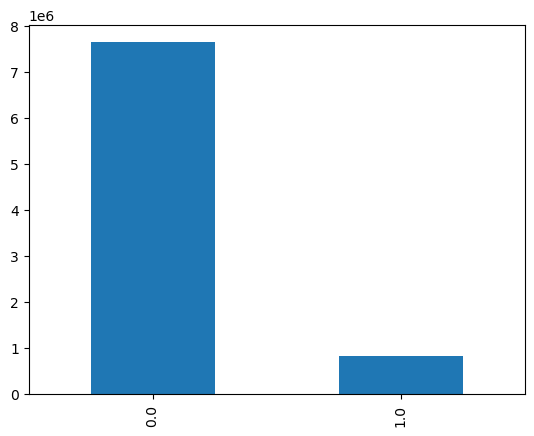

In [324]:
train_data.reordered.value_counts().plot.bar()

- Imbalanced dataset

In [325]:
# train_data.to_csv('data/modelling/train_data_14_features.csv', index=False)

In [326]:
train_data.describe().apply(lambda x: x.apply('{0:.5f}'.format))


,user_id,product_id,up_product_cnt,up_reorder_ratio,up_mean_cart_position,up_mean_days_between_orders,up_mean_order_dow,up_mean_order_hod,u_total_orders,u_mean_products,u_mean_days_between_orders,u_mean_order_dow,p_mean_cart_position,p_order_count,p_reorder_ratio,p_mean_days_between_orders,reordered
count,8474661.00000,8474661.00000,8474661.00000,8474661.00000,8474661.00000,8474661.00000,8474661.00000,8474661.00000,8474661.00000,8474661.00000,8474661.00000,8474661.00000,8474661.00000,8474661.00000,8474661.00000,8474661.00000,8474661.00000
mean,102980.03809,25511.71188,2.43573,0.26551,9.21021,11.45428,2.75506,13.52742,25.38913,12.68250,11.61492,2.74518,8.72570,22510.75383,0.53455,10.47950,0.09780
std,59458.92663,14225.13582,3.54931,0.33973,6.99119,8.92781,1.83901,3.71231,22.23894,6.28536,5.27626,0.79947,1.56317,55856.42370,0.16245,1.01629,0.29704
min,1.00000,1.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,3.00000,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000
25%,51620.00000,13292.00000,1.00000,0.00000,4.00000,5.00000,1.00000,11.00000,9.00000,8.25000,7.36111,2.28571,7.93807,1053.00000,0.44189,9.86221,0.00000
50%,102590.00000,25640.00000,1.00000,0.00000,7.50000,8.80000,2.78261,13.50000,18.00000,11.52525,10.96774,2.76923,8.93264,4316.00000,0.55972,10.35951,0.00000
75%,154607.00000,38156.00000,2.00000,0.50000,12.00000,16.12500,4.00000,16.00000,35.00000,15.90000,15.45455,3.20588,9.75198,16535.00000,0.65173,10.99668,0.00000
max,206209.00000,49688.00000,99.00000,0.98990,145.00000,30.00000,6.00000,23.00000,99.00000,70.25000,27.00000,6.00000,53.00000,472565.00000,0.94118,30.00000,1.00000


### Relationship between product features and target variable

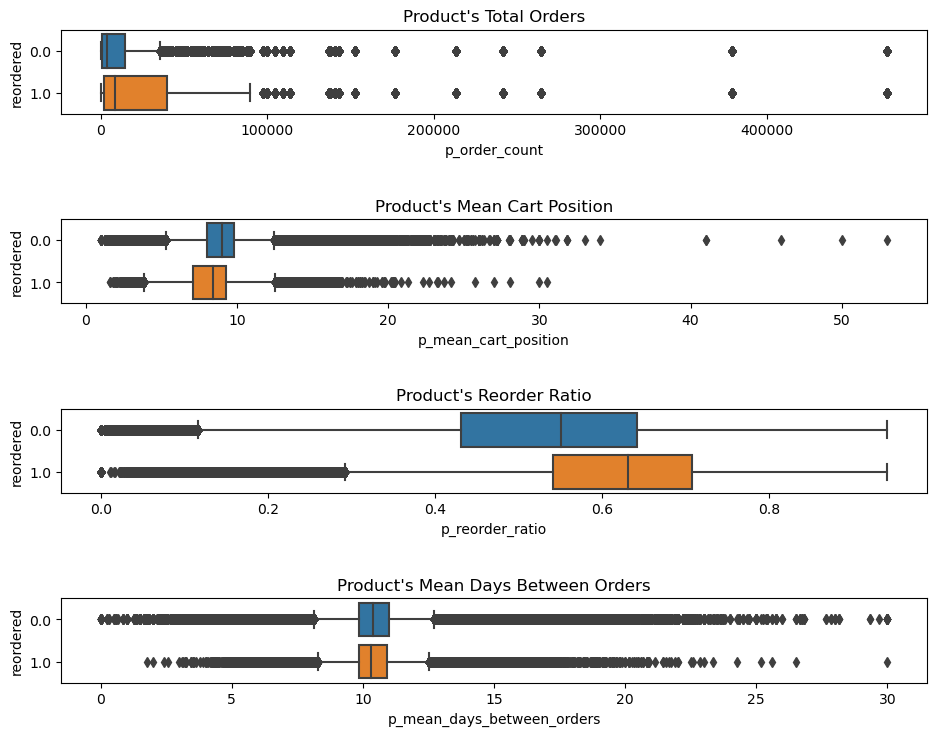

In [339]:
fig, axes = plt.subplots(4, 1, figsize = (10,8))
sns.boxplot(ax=axes[0], data=train_data, y='reordered', x='p_order_count', orient='h')
axes[0].set_title("Product's Total Orders")

sns.boxplot(ax=axes[1], data=train_data, y='reordered', x='p_mean_cart_position', orient='h')
axes[1].set_title("Product's Mean Cart Position")

sns.boxplot(ax=axes[2], data=train_data, y='reordered', x='p_reorder_ratio', orient='h')
axes[2].set_title("Product's Reorder Ratio")

sns.boxplot(ax=axes[3], data=train_data, y='reordered', x='p_mean_days_between_orders', orient='h')
axes[3].set_title("Product's Mean Days Between Orders")

fig.tight_layout(pad=3.0)

### Relationship between user features and target variable

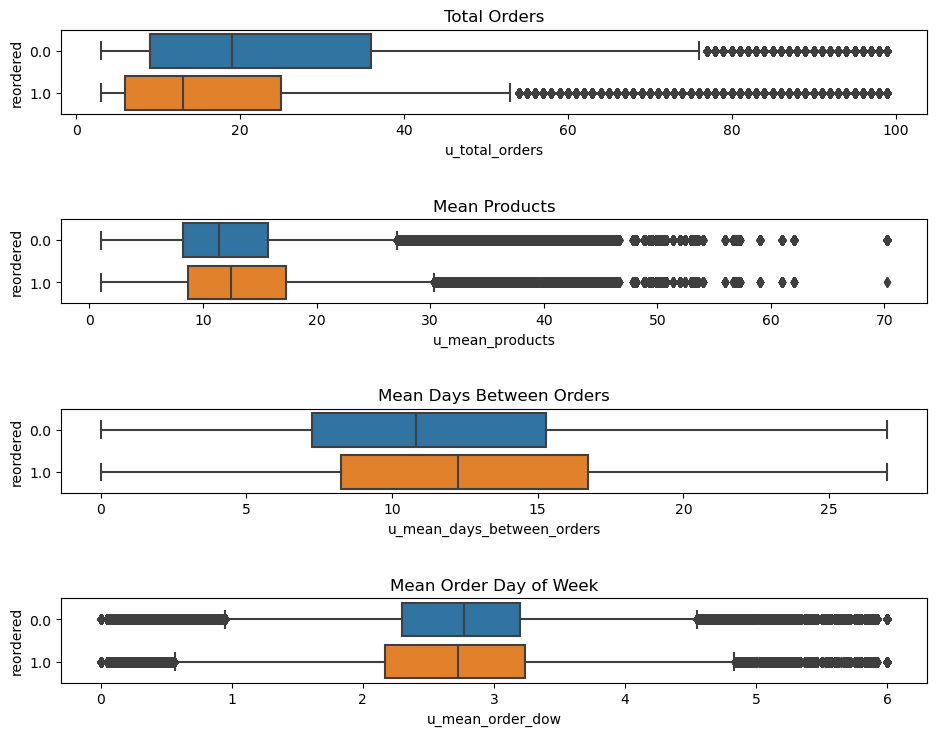

In [331]:
fig, axes = plt.subplots(4, 1, figsize = (10,8))
sns.boxplot(ax=axes[0], data=train_data, y='reordered', x='u_total_orders', orient='h')
axes[0].set_title('Total Orders')

sns.boxplot(ax=axes[1], data=train_data, y='reordered', x='u_mean_products', orient='h')
axes[1].set_title('Mean Products')

sns.boxplot(ax=axes[2], data=train_data, y='reordered', x='u_mean_days_between_orders', orient='h')
axes[2].set_title('Mean Days Between Orders')

sns.boxplot(ax=axes[3], data=train_data, y='reordered', x='u_mean_order_dow', orient='h')
axes[3].set_title('Mean Order Day of Week')

fig.tight_layout(pad=3.0)

### Relationship between user-product features and target variable

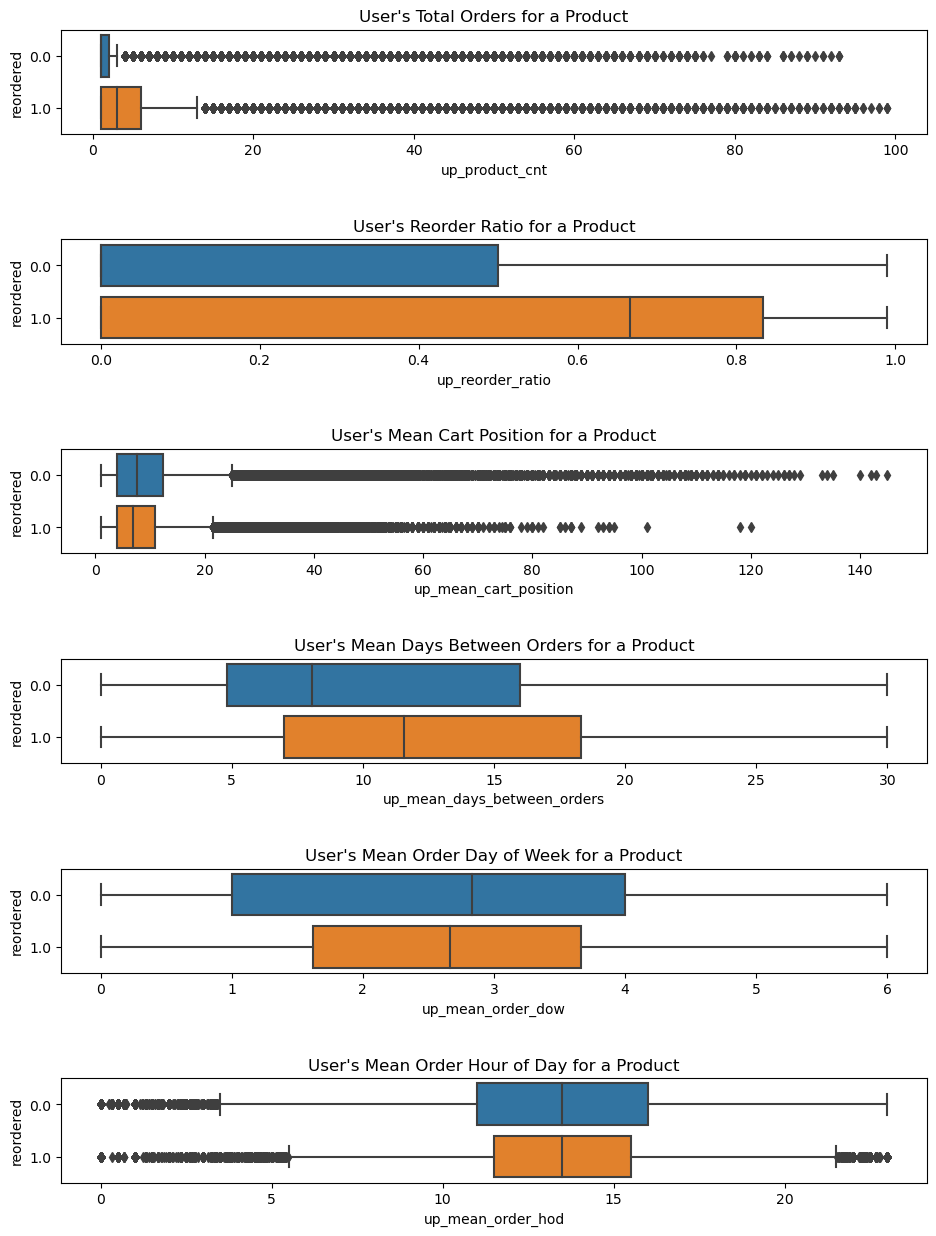

In [343]:
fig, axes = plt.subplots(6, 1, figsize = (10,13))
sns.boxplot(ax=axes[0], data=train_data, y='reordered', x='up_product_cnt', orient='h')
axes[0].set_title("User's Total Orders for a Product")

sns.boxplot(ax=axes[1], data=train_data, y='reordered', x='up_reorder_ratio', orient='h')
axes[1].set_title("User's Reorder Ratio for a Product")

sns.boxplot(ax=axes[2], data=train_data, y='reordered', x='up_mean_cart_position', orient='h')
axes[2].set_title("User's Mean Cart Position for a Product")

sns.boxplot(ax=axes[3], data=train_data, y='reordered', x='up_mean_days_between_orders', orient='h')
axes[3].set_title("User's Mean Days Between Orders for a Product")

sns.boxplot(ax=axes[4], data=train_data, y='reordered', x='up_mean_order_dow', orient='h')
axes[4].set_title("User's Mean Order Day of Week for a Product")

sns.boxplot(ax=axes[5], data=train_data, y='reordered', x='up_mean_order_hod', orient='h')
axes[5].set_title("User's Mean Order Hour of Day for a Product")

fig.tight_layout(pad=3.0)